D:\pytorchMethod\pytorchClassification2\pytorchEnv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
save dir ./savefile/resnet50d_pretrained_224 created
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
-------------------
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

Epoch: 1. Train.      Loss: 0.121 | F1: 0.947 | Recall: 0.948 | Accuracy: 0.966: 100%|█| 2090/2090 [06:49<00:00,  5.11i
Epoch: 1. Validation. Loss: 0.128 | F1: 0.924 | Recall: 0.920 | Accuracy: 0.971: 100%|█| 696/696 [01:05<00:00, 10.56it/
Epoch: 2. Train.      Loss: 0.020 | F1: 0.989 | Recall: 0.989 | Accuracy: 0.994: 100%|█| 2090/2090 [06:36<00:00,  5.27i
Epoch: 2. Validation. Loss: 0.002 | F1: 0.996 | Recall: 0.996 | Accuracy: 0.999: 100%|█| 696/696 [01:04<00:00, 10.85it/
Epoch: 3. Train.      Loss: 0.011 | F1: 0.994 | Recall: 0.995 | Accuracy: 0.997: 100%|█| 2090/2090 [06:36<00:00,  5.27i
Epoch: 3. Validation. Loss: 0.002 | F1: 0.996 | Recall: 0.996 | Accuracy: 1.000: 100%|█| 696/696 [01:06<00:00, 10.51it/
Epoch: 4. Train.      Loss: 0.006 | F1: 0.998 | Recall: 0.998 | Accuracy: 0.999: 100%|█| 2090/2090 [13:57<00:00,  2.50i
Epoch: 4. Validation. Loss: 0.003 | F1: 0.995 | Recall: 0.995 | Accuracy: 0.999: 100%|█| 696/696 [01:32<00:00,  7.53it/
Epoch: 5. Train.      Loss: 0.003 | F1: 

training has done, model and the train message save at: ./savefile/resnet50d_pretrained_224


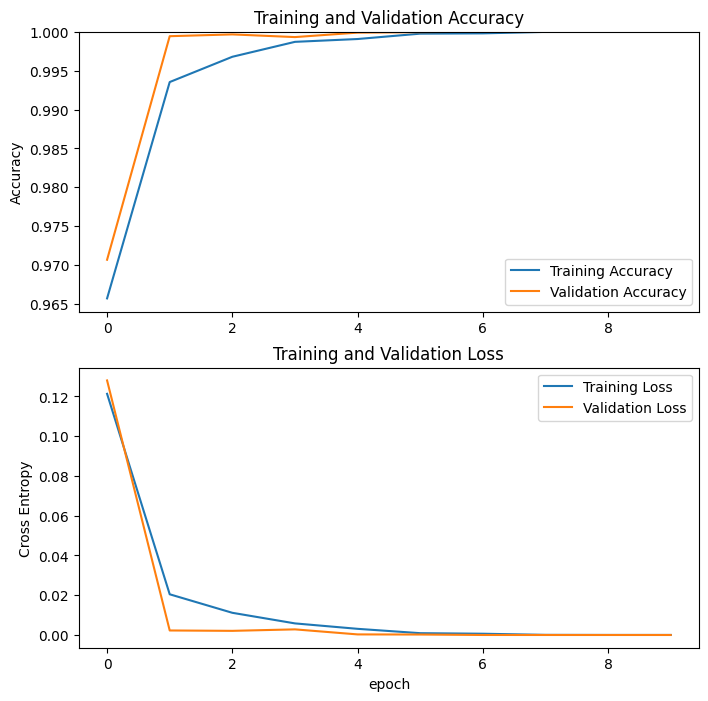

In [3]:
import torch
import os.path as osp
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
import math
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, recall_score
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import datasets, models, transforms

# set to gpu
if torch.cuda.is_available():
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')
print(f'Using device: {dev}')

# fix the random seeds，make sure the result can be retaken
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# model set up

data_path = "gestureDatabase_split20240122"
params = {
    # 'model': 'vit_tiny_patch16_224',
    'model':'resnet50d',
    #'model': 'efficientnet_b3a',
    "img_size": 224,
    "train directory": osp.join(data_path, "train"),
    "val directory": osp.join(data_path, "val"),
    'device': dev,
    'lr': 1e-3,  # learning rate
    'batch_size': 25,  # batch size
    'numberOfWorkers': 10,  # the procedure  since we are running in windows, cannot change
    'epochs': 10,  # the running circle number, if the effect no well, then try a bigger number, like 50
    "save_dir": "./savefile/",  # todo the save path(model and trainng result message)
    "pretrained": True,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),  # classification numer,self get number
    'weight_decay': 1e-5  # learning rate decreasing rate
}


# ----------------


class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if model_name[:3] == "res":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, out_features)
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)

        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x


# define training procuder
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()  # set data monitor
    model.train()  # set to train mode
    numBatch = len(train_loader)
    stream = tqdm(train_loader)  # set it to show the process
    for i, (images, target) in enumerate(stream, start=1):  # begin training
        # load data
        images = images.to(params['device'], non_blocking=True)
        target = target.to(params['device'], non_blocking=True)
        output = model(images)
        # calculate relavent data
        loss = criterion(output, target.long())  # count loss
        f1_macro = calculate_f1_macro(output, target)  # count f1 number
        recall_macro = calculate_recall_macro(output, target)  # ount recall number
        acc = accuracy(output, target)
        # update the relavent data
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('F1', f1_macro)
        metric_monitor.update('Recall', recall_macro)
        metric_monitor.update('Accuracy', acc)
        # set up optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr = adjust_learning_rate(optimizer, epoch, params, i, numBatch)
        # display this whole procedure
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(
                epoch=epoch,
                metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['Loss']["avg"]


def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    # set model to evaluate
    model.eval()
    stream = tqdm(val_loader)
    # begin infer
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)  # read picture
            target = target.to(params['device'], non_blocking=True)  # read label
            output = model(images)  # front spread
            # calculate relavent data
            loss = criterion(output, target.long())  # count loss
            f1_macro = calculate_f1_macro(output, target)  # count f1 fraction
            recall_macro = calculate_recall_macro(output, target)  # count recall fraction
            acc = accuracy(output, target)  # count acc
            # update the relavent data
            metric_monitor.update('Loss', loss.item())  # update the completion rate
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            # display this whole procedure
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(
                    epoch=epoch,
                    metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['Loss']["avg"]


# ------------------------------------------------

# def how to plot the final pictrure
def show_loss_acc(acc, loss, val_acc, val_loss, save_dir):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    # save tp savedir
    save_path = osp.join(save_dir, "results.png")
    plt.savefig(save_path, dpi=100)


# ----------------------------------

# use touch vision to transform data,otherwise it cannot match the input and ouput data
def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            # transforms.RandomResizedCrop(img_size),
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            # transforms.Resize((img_size, img_size)),
            # transforms.Resize(256),
            # transforms.CenterCrop(img_size),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


def get_train_transforms(img_size=320):
    return albumentations.Compose(
        [
            albumentations.Resize(img_size, img_size),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            # albumentations.RandomBrightnessContrast(),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            # albumentations.Random
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0),
        ]
    )


def get_valid_transforms(img_size=224):
    return albumentations.Compose(
        [
            albumentations.Resize(img_size, img_size),
            albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], max_pixel_value=255.0,
                                     always_apply=True),
            ToTensorV2(p=1.0)
        ]
    )


# -----------------------------------

class LeafDataset(Dataset):
    def __init__(self, images_filepaths, labels, transform=None):
        self.images_filepaths = images_filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        # print(image_filepath)
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

    # -----------------------------------


# def how to calculate the data

def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()

    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()

    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


# --------------------------------

def adjust_learning_rate(optimizer, epoch, params, batch=0, nBatch=None):
    """ adjust learning of a given optimizer and return the new learning rate """
    new_lr = calc_learning_rate(epoch, params['lr'], params['epochs'], batch, nBatch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr


def calc_learning_rate(epoch, init_lr, n_epochs, batch=0, nBatch=None, lr_schedule_type='cosine'):
    if lr_schedule_type == 'cosine':
        t_total = n_epochs * nBatch
        t_cur = epoch * nBatch + batch
        lr = 0.5 * init_lr * (1 + math.cos(math.pi * t_cur / t_total))
    elif lr_schedule_type is None:
        lr = init_lr
    else:
        raise ValueError('do not support: %s' % lr_schedule_type)
    return lr


# -----------------------------------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# --------------------------------

if __name__ == '__main__':
    accs = []
    losss = []
    val_accs = []
    val_losss = []
    data_transforms = get_torch_transforms(img_size=params["img_size"])  # obtain image pre processing method
    train_transforms = data_transforms['train']
    valid_transforms = data_transforms['val']
    train_dataset = datasets.ImageFolder(params["train directory"], train_transforms)  # laod trainset
    valid_dataset = datasets.ImageFolder(params["val directory"], valid_transforms)  # laod val set
    if params['pretrained'] == True:
        save_dir = osp.join(params['save_dir'], params['model'] + "_pretrained_" + str(params["img_size"]))
    else:
        save_dir = osp.join(params['save_dir'], params['model'] + "_nopretrained_" + str(params["img_size"]))
    if not osp.isdir(save_dir):
        os.makedirs(save_dir)
        print("save dir {} created".format(save_dir))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True,
                              num_workers=params['numberOfWorkers'], pin_memory=True)
    val_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False,
                            num_workers=params['numberOfWorkers'], pin_memory=True)
    print(train_dataset.classes)
    print('-------------------')
    print(valid_dataset.classes)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=params['pretrained'])
    model = model.to(params['device'])
    criterion = nn.CrossEntropyLoss().to(params['device'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    best_acc = 0.0  # recode the best accuracy
    # save the best model
    for epoch in range(1, params['epochs'] + 1):  # begin training
        acc, loss = train(train_loader, model, criterion, optimizer, epoch, params)
        val_acc, val_loss = validate(val_loader, model, criterion, epoch, params)
        accs.append(acc)
        losss.append(loss)
        val_accs.append(val_acc)
        val_losss.append(val_loss)
        if val_acc >= best_acc:
            save_path = osp.join(save_dir, f"{params['model']}_{epoch}epochs_accuracy{acc:.5f}_weights.pth")
            torch.save(model.state_dict(), save_path)
            best_acc = val_acc
    show_loss_acc(accs, losss, val_accs, val_losss, save_dir)
    print("training has done, model and the train message save at: {}".format(save_dir))